# Notebook dependencies

Please make sure that you calibrated camera once using [solution_calibrate.ipynb](solution_calibrate.ipynb#Calibrate-camera) before using this notebook


# Import dependencies

In [31]:
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# For edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Lane detection state

State current lane detection session that consists of ...

 - **roiVertices**, a coordinate array with region of interest vertices that draws the boundaries for estimated lane area from the camera perspective
 - **birdsEyeLaneVertices**, a coordinate array with estimated point alignment for camera input in 2D birds-eye-view perspective.
 - **cameraLaneVertices**, a coordinate array with estimated point alignment for birds-eye-view in 2D camera perspective.
 - **mtx**, camera matrix for removing distortion
 - **dist**, distortion coefficient for removing distortion
 - **leftFit**, last known left lane polynomial
 - **rightFit**, last known right lane polynomial

In [32]:
class State:
    def __init__(self):
        self.reset()
        
    def calibrateOnce(self, image):
        if self.roiVertices is not None:
            return
        if self.birdsEyeLaneVertices is not None:
            return
        if self.cameraLaneVertices is not None:
            return
        
        height, width, channel = image.shape
        self.height = height
        self.width = width
        # Used to filter out noise or perform sanity check on calculated base lane points
        self.minimumLaneBaseDistance = width * 0.25
        self.minimumLaneCutoffY = height * 0.4

        # Used to mask noise outside estimated lane region
        self.roiVertices = np.array([[
            (width * 0.45, height * 0.6), # Top left
            (width * 0.10, height * 0.95), # Bottom left
            (width * 0.90, height * 0.95), # Bottom right
            (width * 0.55, height * 0.6), # Top right
        ]], dtype=np.int32)

        # Used to transform image from camera perspective to birds-eye perspective
        self.birdsEyeLaneVertices = np.float32([
            [width * 0.25, 0], # Top left
            [width * 0.25, height], # Bottom left
            [width * 0.75, height], # Bottom right
            [width * 0.75, 0], # Top right
        ])

        # Used to transform image from birds-eye perspective to camera perspective
        self.cameraLaneVertices = np.float32([
            [width * 0.4745, height * 0.61], # Top left
            [width * 0.190, height * 0.95], # Bottom left
            [width * 0.810, height * 0.95], # Bottom right
            [width * 0.5255, height * 0.61], # Top right
        ])
        
        # Used to convert pixels space in x and y to meters 
        # These are based on an assumption that the processed lane in birds eye view is 30m long and 3.7 meter wide
        self.mPerPixY = 30/height # meters per pixel in y dimension
        self.mPerPixX = 3.7/(width * 0.5) # meters per pixel in x dimension. The width coefficient should align with birdsEyeLaneVertices bottom diff

    
    def reset(self):
        # Read in the saved camera matrix and distortion coefficients
        # These are the arrays you calculated using cv2.calibrateCamera()
        dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
        self.mtx = dist_pickle["mtx"]
        self.dist = dist_pickle["dist"]
        
        # Define values for last known left & right fit polynomials
        self.leftFit = None
        self.rightFit = None
        
        # Define input dimensions
        self.width = 0
        self.height = 0
        self.minimumLaneBaseDistance = 0
        self.minimumLaneCutoffY = 0
        self.mPerPixY = 1
        self.mPerPixX = 1
        
        # Define vertices for image processing
        self.roiVertices = None
        self.birdsEyeLaneVertices = None
        self.cameraLaneVertices = None
        
        # Define colors for lane rendering
        self.laneColor = (0, 255, 255)
        self.leftLaneColor= (0, 0, 255)
        self.rightLaneColor = (255, 0, 0)

# Lane detection functions

In [53]:
def undistord(image, mtx, dist, newcameramtx):
    return cv2.undistort(image, mtx, dist, None, mtx)


# image needs to be a single channel 8-bit image
def __binarize(image, threshold):
    binary = np.zeros_like(image)
    threshold_min, threshold_max = threshold
    binary[(image > threshold_min) & (image <= threshold_max)] = 1
    
    return binary


def gradientBinary(image, threshold):
    imageGrayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    sobel = cv2.Sobel(imageGrayscale, cv2.CV_64F, 1, 0)
    sobelAbsolute = np.absolute(sobel)
    
    # normalize
    sobelAbsoluteMax = np.max(sobelAbsolute)
    sobel8bit = np.uint8(255 * sobelAbsolute/sobelAbsoluteMax)
    
    return __binarize(sobel8bit, threshold)


def saturationBinary(image, threshold):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]

    return __binarize(S, threshold)


def removeEnvironmentNoise(image, vertices, debug=False):
    # Vertices suggested by the reviewer
    #vertices = np.array([[(0,image.shape[0]),(400, 320), (600, 320), (image.shape[1],image.shape[0])]], dtype=np.int32)
    maskedEdgeImage = __regionOfInterest(image, vertices)
    return maskedEdgeImage if not debug else __debugMask(maskedEdgeImage, vertices)


def __regionOfInterest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def __debugMask(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.polylines(mask, np.int32([vertices]), True, ignore_mask_color, 4)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.addWeighted(img, 1, mask, 0.5, 0)
    return masked_image


def __binaryImageActivationHistogram(image): 
    height, width = image.shape
    bottom_half = image[(int(round(height*0.4))):,:]
    histogram = np.sum(bottom_half, axis = 0)
    
    rollingRange = width * 0.1
    rollingAverageHistogram = np.array([np.average(histogram[i-rollingRange:i+rollingRange]) for i in range(len(histogram))])
    rollingAverageHistogram[np.isnan(rollingAverageHistogram)] = 0
    
    return rollingAverageHistogram


def findHorizontalLaneBases(image, debug=False):
    ## TODO: This still finds some false positive values
    histogram = __binaryImageActivationHistogram(image)
    peakPoints = __findPeakPoints(histogram, 1, 1)
    peakPoints.sort(key=lambda x:x[1], reverse=True)
    
    height, width = image.shape
    
    if debug:
        print("Peak-a-boo: ", peakPoints)
        print("Min lane distance: ", state.minimumLaneBaseDistance)
        plt.plot(histogram)
    
    if len(peakPoints) < 2:
        return None, None
    
    for i in range(len(peakPoints) - 1):
        highestPeakPoint = peakPoints[i]
        
        for i in range(1, len(peakPoints)):
            currentPeakPoint = peakPoints[i]
            if np.absolute(currentPeakPoint[0] - highestPeakPoint[0]) > state.minimumLaneBaseDistance:
                if currentPeakPoint[0] < highestPeakPoint[0]:
                    return currentPeakPoint[0], highestPeakPoint[0]
                else:
                    return highestPeakPoint[0], currentPeakPoint[0]
    
    return None, None


def __findPeakPoints(singleDimensionArray, lookupRange = 1, threshold = 0):
    peakPoints = []
    
    pointPrior = 0
    pointCurrent = 0
    pointSuccessor = 0
    
    for i in range(lookupRange, len(singleDimensionArray) - lookupRange):
        pointPrior = singleDimensionArray[i - lookupRange]
        pointCurrent = singleDimensionArray[i]
        pointSuccessor = singleDimensionArray[i + lookupRange]
        
        if pointCurrent > threshold and pointPrior <= pointCurrent >= pointSuccessor:
            peakPoints.append((i, pointCurrent))
            
    return peakPoints


def __findLanePixelsSlidingWindow(image, leftBaseX, rightBaseX, debug=False):
    # Create an output image to draw on and visualize the result
    outImg = np.dstack((image, image, image))
    height, width = image.shape
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(height//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftCurrentX = leftBaseX
    rightCurrentX = rightBaseX

    # Create empty lists to receive left and right lane pixel indices
    leftLaneInds = []
    rightLaneInds = []
    leftLaneCutoffY = 0
    rightLaneCutoffY = 0

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftCurrentX - margin
        win_xleft_high = leftCurrentX + margin
        win_xright_low = rightCurrentX - margin
        win_xright_high = rightCurrentX + margin
        
        if debug:
            # Draw the windows on the visualization image
            cv2.rectangle(outImg,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(outImg,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        if leftLaneCutoffY == 0:
            # Identify the nonzero pixels in x and y within the window #
            goodLeftInds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            # Append these indices to the lists
            leftLaneInds.append(goodLeftInds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(goodLeftInds) > minpix:
                leftCurrentX = np.int(np.mean(nonzerox[goodLeftInds]))
                if leftCurrentX - margin <= 0:
                    leftLaneCutoffY = win_y_low
                    if debug:
                        print("Found left cutoff: ", leftLaneCutoffY)
        
        if rightLaneCutoffY == 0:
            # Identify the nonzero pixels in x and y within the window #
            goodRightInds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            rightLaneInds.append(goodRightInds)
            if len(goodRightInds) > minpix:        
                rightCurrentX = np.int(np.mean(nonzerox[goodRightInds]))
                if rightCurrentX + margin >= width:
                    rightLaneCutoffY = win_y_low
                    if debug:
                        print("Found right cutoff: ", rightLaneCutoffY)
    
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        leftLaneInds = np.concatenate(leftLaneInds)
        rightLaneInds = np.concatenate(rightLaneInds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[leftLaneInds]
    lefty = nonzeroy[leftLaneInds]
    rightx = nonzerox[rightLaneInds]
    righty = nonzeroy[rightLaneInds]

    return leftx, lefty, rightx, righty, outImg, leftLaneCutoffY, rightLaneCutoffY


def __findLanePixelsPrior(image, leftFit, rightFit, debug=False):
    margin = 50
    
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    leftLaneInds = ((nonzerox > (leftFit[0]*(nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] - margin)) & 
                      (nonzerox < (leftFit[0]*(nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] + margin)))
    rightLaneInds = ((nonzerox > (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] - margin)) & 
                      (nonzerox < (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] + margin)))
    
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        leftLaneInds = np.concatenate(leftLaneInds)
        rightLaneInds = np.concatenate(rightLaneInds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[leftLaneInds]
    lefty = nonzeroy[leftLaneInds] 
    rightx = nonzerox[rightLaneInds]
    righty = nonzeroy[rightLaneInds]

    return leftx, lefty, rightx, righty, np.dstack((image, image, image))


def __polyfit(yPixels, xPixels):
    # This is the place where we draw the lane trajectory
    # Fit a second order polynomial to each using `np.polyfit`
    # x = y^2 + y + c
    # ???
    # return np.polyfit(yPixels * state.mPerPixY, xPixels * state.mPerPixX, 2)
    return np.polyfit(yPixels, xPixels, 2)

# 
# - leftLaneX, polyfitted lane pixels
# - leftLaneY, polyfitted lane pixels
# - rightLaneX, polyfitted lane pixels
# - rightLaneY, polyfitted lane pixels
# - leftx, activated lane pixels (from extracted features/binary image)
# - lefty, activated lane pixels (from extracted features/binary image)
# - rightx, activated lane pixels (from extracted features/binary image)
# - righty, activated lane pixels (from extracted features/binary image)
#
def __plotLanes(image, leftLaneX, leftLaneY, rightLaneX, rightLaneY, leftx, lefty, rightx, righty):
    ## Visualization ##
    # Colors in the left and right lane regions
    image[lefty, leftx] = state.leftLaneColor
    image[righty, rightx] = state.rightLaneColor
    
    leftLanePoints = np.array([np.transpose(np.vstack([leftLaneX, leftLaneY]).astype(int))])
    # Flip for drawing a quadruple shape, rather than a butterfly
    rightLanePoints = np.array([np.flipud(np.transpose(np.vstack([rightLaneX, rightLaneY]).astype(int)))])
    
    lanePoints = np.hstack((leftLanePoints, rightLanePoints))
    cv2.fillPoly(image, lanePoints, state.laneColor)


def __generateLanePixels(image, fitPolynomial, laneCutoffY = 0):
    # Generate y values for plotting
    plotY = np.linspace(laneCutoffY, image.shape[0]-1, image.shape[0]-laneCutoffY)
    
    # Calculate x values for plotting
    plotX = fitPolynomial[0]*plotY**2 + fitPolynomial[1]*plotY + fitPolynomial[2]
        
    return plotX, plotY


def fitPolynomialSlidingWindow(image, leftBaseX, rightBaseX, debug=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, outImg, leftLaneCutoffY, rightLaneCutoffY = __findLanePixelsSlidingWindow(image, leftBaseX, rightBaseX, debug)

    leftFit = __polyfit(lefty, leftx)
    rightFit = __polyfit(righty, rightx)
    
    leftFitInMeters = __polyfit(lefty * state.mPerPixY, leftx * state.mPerPixX)
    rightFitInMeters = __polyfit(righty * state.mPerPixY, rightx * state.mPerPixX)
    
    leftLaneCutoffY = max(state.minimumLaneCutoffY, leftLaneCutoffY)
    rightLaneCutoffY = max(state.minimumLaneCutoffY, rightLaneCutoffY)
    
    leftFitX, leftFitY = __generateLanePixels(outImg, leftFit, leftLaneCutoffY)
    rightFitX, rightFitY = __generateLanePixels(outImg, rightFit, rightLaneCutoffY)

    __plotLanes(outImg, leftFitX, leftFitY, rightFitX, rightFitY, leftx, lefty, rightx, righty)
    
    leftCurvature = calculateCurvature(leftFitInMeters, state.height * state.mPerPixY)
    rightCurvature = calculateCurvature(rightFitInMeters, state.height * state.mPerPixY)
    
    averageCurvature = (leftCurvature + rightCurvature) * 0.5
    
    height, width = image.shape
    leftLaneX = leftFit[0]*height**2 + leftFit[1]*height + leftFit[2]
    rightLaneX = rightFit[0]*height**2 + rightFit[1]*height + rightFit[2]
    lanePosition = (width - (leftLaneX + rightLaneX)) * 0.5 * state.mPerPixX
    
    return outImg, leftFit, rightFit, averageCurvature, lanePosition


def fitPolynomialPrior(image, leftFit, rightFit, debug=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, outImg = __findLanePixelsPrior(image, leftFit, rightFit, debug)
    
    leftFit = __polyfit(lefty, leftx)
    rightFit = __polyfit(righty, rightx)
    
    leftFitInMeters = __polyfit(lefty * state.mPerPixY, leftx * state.mPerPixX)
    rightFitInMeters = __polyfit(righty * state.mPerPixY, rightx * state.mPerPixX)
    
    # Validate left & right fit lane distance at the image bottom
    height, width = image.shape
    leftLaneX = leftFit[0]*height**2 + leftFit[1]*height + leftFit[2]
    rightLaneX = rightFit[0]*height**2 + rightFit[1]*height + rightFit[2]
    
    if rightLaneX - leftLaneX < state.minimumLaneBaseDistance:
        return outImg, None, None, 0, 0
    
    laneCutoffY = state.minimumLaneCutoffY
    
    leftFitX, leftFitY = __generateLanePixels(outImg, leftFit, laneCutoffY)
    rightFitX, rightFitY = __generateLanePixels(outImg, rightFit, laneCutoffY)

    __plotLanes(outImg, leftFitX, leftFitY, rightFitX, rightFitY, leftx, lefty, rightx, righty)

    leftCurvature = calculateCurvature(leftFitInMeters, state.height * state.mPerPixY)
    rightCurvature = calculateCurvature(rightFitInMeters, state.height * state.mPerPixY)
    
    averageCurvature = (leftCurvature + rightCurvature) * 0.5
    lanePosition = (width - (leftLaneX + rightLaneX)) * 0.5 * state.mPerPixX
    
    return outImg, leftFit, rightFit, averageCurvature, lanePosition


def warp(image, srcVertices, dstVertices, dstSize, debug=False):
    transformationMatrix = cv2.getPerspectiveTransform(srcVertices, dstVertices)
    warpedImage = cv2.warpPerspective(image, transformationMatrix, dstSize)
    return warpedImage if not debug else __debugMask(warpedImage, dstVertices)
    
    
def calculateCurvature(polynomial, y=0):
    return ((1 + (2*polynomial[0]*y + polynomial[1]) ** 2) ** 1.5) / np.absolute(2 * polynomial[0])
    

def renderInfoText(image, laneCurvature, lanePosition):
    lanePositionReferenceText = "center" if lanePosition == 0 else "right" if lanePosition > 0 else "left"
    curvatureInfoText = "Radius of curvature = {}(m)".format(int(round(laneCurvature)))
    lanePositionInfoText = "Vehicle is {:.2f}m {} of center".format(np.absolute(lanePosition), lanePositionReferenceText)
    cv2.putText(image,curvatureInfoText,(100,100), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),4,cv2.LINE_AA)
    cv2.putText(image,lanePositionInfoText,(100,180), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),4,cv2.LINE_AA)




# Image processor

In [34]:


def processImage(image, debug=False):
    state.calibrateOnce(image)
    
    imageUndistorted = undistord(image, state.mtx, state.dist, state.mtx)
    imageGradientBinary = gradientBinary(imageUndistorted, (20, 100))
    imageSaturationBinary = saturationBinary(imageUndistorted, (70, 255))

    # Combine the two binary thresholds
    imageBinaryCombined = np.zeros_like(imageGradientBinary)
    imageBinaryCombined[(imageGradientBinary == 1) | (imageSaturationBinary == 1)] = 1
    
    imageBinaryDenoised = removeEnvironmentNoise(imageBinaryCombined, state.roiVertices)
    imageBinaryBirdsEye = warp(imageBinaryDenoised, state.cameraLaneVertices, state.birdsEyeLaneVertices, (state.width, state.height))
    
    if state.leftFit is None or state.rightFit is None:
        leftBaseX, rightBaseX = findHorizontalLaneBases(imageBinaryBirdsEye, debug)
        if leftBaseX is None or rightBaseX is None:
            if debug:
                print("Lane X-Bases are not found")
            return imageUndistorted

        if debug:
            print("LBX: ", leftBaseX)
            print("RBX: ", rightBaseX)
            print("Sliding window")
        
        imageLaneMaskBirdsEye, leftFit, rightFit, laneCurvature, lanePosition = fitPolynomialSlidingWindow(imageBinaryBirdsEye, leftBaseX, rightBaseX, debug)
        state.leftFit = leftFit
        state.rightFit = rightFit
    else:
        if debug:
            print("Prior")
            
        imageLaneMaskBirdsEye, leftFit, rightFit, laneCurvature, lanePosition = fitPolynomialPrior(imageBinaryBirdsEye, state.leftFit, state.rightFit)
        state.leftFit = leftFit
        state.rightFit = rightFit
    
#     return imageLaneMaskBirdsEye
    imageLaneMask = warp(imageLaneMaskBirdsEye, state.birdsEyeLaneVertices, state.cameraLaneVertices, (state.width, state.height))
    
    renderInfoText(imageUndistorted, laneCurvature, lanePosition)
    
    return cv2.addWeighted(imageLaneMask, 0.4, imageUndistorted, 1, 0)


# Debug processor

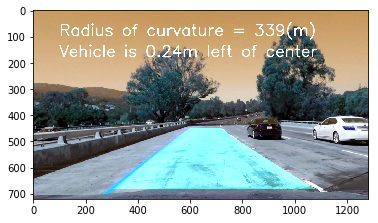

In [54]:
images = glob.glob('./test_images/test*.jpg')
# images = glob.glob('./test_images/test*.jpg')
sampleImage = cv2.imread(images[3])

state = State()
# foo = np.array([1,2,3,4,3,2,1])
# bar = (foo > 2).nonzero()[0]
# print(bar)

# foo = processImage(sampleImage, True)
# plt.imshow(cv2.cvtColor(processImage(sampleImage, False), cv2.COLOR_BGR2RGB))
plt.imshow(processImage(sampleImage, False), cmap="gray")
# plt.imshow(cv2.cvtColor(sampleImage, cv2.COLOR_BGR2RGB))
# plt.plot(histogram)


# Generate sample images

Processes given test images and stores both input and output images into disk

In [56]:
def outputPaths(index):
    pathPattern = './solution_output/lane_detection_images/{:02d}-{}.jpg'
    
    return (
        pathPattern.format(index, "1-input"),
        pathPattern.format(index, "2-step-binary-input"),
        pathPattern.format(index, "3-output-step-binary-sobel"),
        pathPattern.format(index, "4-output-step-binary-saturation"),
        pathPattern.format(index, "5-output-step-binary-combined"),
        pathPattern.format(index, "6-input-step-perspective"),
        pathPattern.format(index, "7-output-step-perspective"),
        pathPattern.format(index, "8-output"),
    )


# Initialize & assign a list of calibration images
images = glob.glob('./test_images/*.jpg')

for i in range(len(images)):
    image = cv2.imread(images[i])
    # Initialize & assign a new state
    state = State()
    # Process
    imageProcessed = processImage(image, False)
    
    # Binary step
    imageUndistorted = undistord(image, state.mtx, state.dist, state.mtx)
    imageGradientBinary = gradientBinary(imageUndistorted, (20, 100))
    imageSaturationBinary = saturationBinary(imageUndistorted, (70, 255))

    ## Combine the two binary thresholds
    imageBinaryCombined = np.zeros_like(imageGradientBinary)
    ## Activated pixels on combined image are marked as 255 for demo.
    imageBinaryCombined[(imageGradientBinary == 1) | (imageSaturationBinary == 1)] = 255
    imageGradientBinary[(imageGradientBinary == 1)] = 255
    imageSaturationBinary[(imageSaturationBinary == 1)] = 255
    
    # Perspective step
    imageBinaryDenoised = removeEnvironmentNoise(imageBinaryCombined, state.roiVertices)
    imagePerspectiveBirdsEye = warp(imageUndistorted, state.cameraLaneVertices, state.birdsEyeLaneVertices, (state.width, state.height), True)
    imagePerspectiveCamera = __debugMask(imageUndistorted, state.cameraLaneVertices)
    
    inputPath, inputStepBinaryPath, outputStepBinarySobelPath, outputStepBinarySaturationPath, outputStepBinaryCombinedPath, inputStepPerspectivePath, outputStepPerspectivePath, outputPath = outputPaths(i)
    cv2.imwrite(inputPath, image)
    cv2.imwrite(outputPath, imageProcessed)
    cv2.imwrite(inputStepBinaryPath, imageUndistorted)
    cv2.imwrite(outputStepBinarySobelPath, imageGradientBinary)
    cv2.imwrite(outputStepBinarySaturationPath, imageSaturationBinary)
    cv2.imwrite(outputStepBinaryCombinedPath, imageBinaryCombined)
    cv2.imwrite(inputStepPerspectivePath, imagePerspectiveCamera)
    cv2.imwrite(outputStepPerspectivePath, imagePerspectiveBirdsEye)
    
    

# Generate sample video clips

Processes given challenge video clips and stores the output images into disk

In [57]:
output1 = 'solution_output/lane_detection_videos/project_video.mp4'
output2 = 'solution_output/lane_detection_videos/harder_challenge_video.mp4'

clip1 = VideoFileClip("project_video.mp4")
clip2 = VideoFileClip("harder_challenge_video.mp4")
state = State()
clipProcessed1 = clip1.fl_image(processImage) #NOTE: this function expects color images!!
clipProcessed1.write_videofile(output1, audio=False)
state.reset()
clipProcessed2 = clip2.fl_image(processImage) #NOTE: this function expects color images!!
clipProcessed2.write_videofile(output2, audio=False)
state.reset()





                                                             
t:   0%|          | 5/1260 [25:32<01:08, 18.28it/s, now=None]
                                                             
t:   0%|          | 5/1260 [25:02<01:09, 17.99it/s, now=None]

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

t:   0%|          | 2/1260 [00:00<01:03, 19.95it/s, now=None]

Moviepy - Building video solution_output/lane_detection_videos/project_video.mp4.
Moviepy - Writing video solution_output/lane_detection_videos/project_video.mp4





t:   0%|          | 4/1260 [00:00<01:13, 17.15it/s, now=None]

t:   0%|          | 6/1260 [00:00<01:20, 15.62it/s, now=None]

t:   1%|          | 8/1260 [00:00<01:24, 14.90it/s, now=None]

t:   1%|          | 10/1260 [00:00<01:24, 14.78it/s, now=None]

t:   1%|          | 12/1260 [00:00<01:25, 14.52it/s, now=None]

t:   1%|          | 14/1260 [00:00<01:26, 14.34it/s, now=None]

t:   1%|▏         | 16/1260 [00:01<01:27, 14.23it/s, now=None]

t:   1%|▏         | 18/1260 [00:01<01:27, 14.26it/s, now=None]

t:   2%|▏         | 20/1260 [00:01<01:27, 14.17it/s, now=None]

t:   2%|▏         | 22/1260 [00:01<01:28, 13.92it/s, now=None]

t:   2%|▏         | 24/1260 [00:01<01:27, 14.20it/s, now=None]

t:   2%|▏         | 26/1260 [00:01<01:23, 14.70it/s, now=None]

t:   2%|▏         | 28/1260 [00:01<01:24, 14.64it/s, now=None]

t:   2%|▏         | 30/1260 [00:02<01:28, 13.94it/s, now=None]

t:   3%|▎         | 32/1260 [00:02<01:28, 13.88it/s, now=None]

t:   3%|▎         | 34/1260 [00:02<01:26,

t:  19%|█▊        | 236/1260 [00:16<01:11, 14.34it/s, now=None]

t:  19%|█▉        | 238/1260 [00:16<01:13, 13.88it/s, now=None]

t:  19%|█▉        | 240/1260 [00:16<01:14, 13.64it/s, now=None]

t:  19%|█▉        | 242/1260 [00:16<01:14, 13.65it/s, now=None]

t:  19%|█▉        | 244/1260 [00:17<01:13, 13.88it/s, now=None]

t:  20%|█▉        | 246/1260 [00:17<01:12, 13.99it/s, now=None]

t:  20%|█▉        | 248/1260 [00:17<01:12, 13.96it/s, now=None]

t:  20%|█▉        | 250/1260 [00:17<01:12, 13.96it/s, now=None]

t:  20%|██        | 252/1260 [00:17<01:13, 13.80it/s, now=None]

t:  20%|██        | 254/1260 [00:17<01:15, 13.40it/s, now=None]

t:  20%|██        | 256/1260 [00:17<01:13, 13.62it/s, now=None]

t:  20%|██        | 258/1260 [00:18<01:13, 13.67it/s, now=None]

t:  21%|██        | 260/1260 [00:18<01:11, 13.93it/s, now=None]

t:  21%|██        | 262/1260 [00:18<01:12, 13.77it/s, now=None]

t:  21%|██        | 264/1260 [00:18<01:11, 13.96it/s, now=None]

t:  21%|██        | 266/1

t:  37%|███▋      | 466/1260 [00:32<00:55, 14.26it/s, now=None]

t:  37%|███▋      | 468/1260 [00:32<00:56, 14.08it/s, now=None]

t:  37%|███▋      | 470/1260 [00:33<00:56, 14.10it/s, now=None]

t:  37%|███▋      | 472/1260 [00:33<00:57, 13.81it/s, now=None]

t:  38%|███▊      | 474/1260 [00:33<00:55, 14.14it/s, now=None]

t:  38%|███▊      | 476/1260 [00:33<00:55, 14.11it/s, now=None]

t:  38%|███▊      | 478/1260 [00:33<00:54, 14.31it/s, now=None]

t:  38%|███▊      | 480/1260 [00:33<00:54, 14.29it/s, now=None]

t:  38%|███▊      | 482/1260 [00:33<00:53, 14.41it/s, now=None]

t:  38%|███▊      | 484/1260 [00:33<00:54, 14.18it/s, now=None]

t:  39%|███▊      | 486/1260 [00:34<00:54, 14.23it/s, now=None]

t:  39%|███▊      | 488/1260 [00:34<00:54, 14.16it/s, now=None]

t:  39%|███▉      | 490/1260 [00:34<00:53, 14.29it/s, now=None]

t:  39%|███▉      | 492/1260 [00:34<00:54, 14.20it/s, now=None]

t:  39%|███▉      | 494/1260 [00:34<00:54, 14.12it/s, now=None]

t:  39%|███▉      | 496/1

t:  55%|█████▌    | 696/1260 [00:49<00:36, 15.45it/s, now=None]

t:  55%|█████▌    | 698/1260 [00:49<00:35, 15.73it/s, now=None]

t:  56%|█████▌    | 700/1260 [00:49<00:34, 16.17it/s, now=None]

t:  56%|█████▌    | 702/1260 [00:49<00:33, 16.59it/s, now=None]

t:  56%|█████▌    | 704/1260 [00:49<00:33, 16.72it/s, now=None]

t:  56%|█████▌    | 706/1260 [00:50<00:32, 17.15it/s, now=None]

t:  56%|█████▌    | 708/1260 [00:50<00:31, 17.37it/s, now=None]

t:  56%|█████▋    | 710/1260 [00:50<00:32, 17.06it/s, now=None]

t:  57%|█████▋    | 712/1260 [00:50<00:32, 16.98it/s, now=None]

t:  57%|█████▋    | 714/1260 [00:50<00:31, 17.38it/s, now=None]

t:  57%|█████▋    | 716/1260 [00:50<00:32, 16.95it/s, now=None]

t:  57%|█████▋    | 718/1260 [00:50<00:31, 17.09it/s, now=None]

t:  57%|█████▋    | 720/1260 [00:50<00:30, 17.52it/s, now=None]

t:  57%|█████▋    | 722/1260 [00:50<00:30, 17.77it/s, now=None]

t:  57%|█████▋    | 724/1260 [00:51<00:30, 17.51it/s, now=None]

t:  58%|█████▊    | 726/1

t:  73%|███████▎  | 926/1260 [01:04<00:21, 15.32it/s, now=None]

t:  74%|███████▎  | 928/1260 [01:05<00:21, 15.28it/s, now=None]

t:  74%|███████▍  | 930/1260 [01:05<00:21, 15.61it/s, now=None]

t:  74%|███████▍  | 932/1260 [01:05<00:20, 15.69it/s, now=None]

t:  74%|███████▍  | 934/1260 [01:05<00:20, 15.90it/s, now=None]

t:  74%|███████▍  | 936/1260 [01:05<00:21, 15.37it/s, now=None]

t:  74%|███████▍  | 938/1260 [01:05<00:20, 15.71it/s, now=None]

t:  75%|███████▍  | 940/1260 [01:05<00:20, 15.90it/s, now=None]

t:  75%|███████▍  | 942/1260 [01:05<00:19, 16.05it/s, now=None]

t:  75%|███████▍  | 944/1260 [01:06<00:19, 16.05it/s, now=None]

t:  75%|███████▌  | 946/1260 [01:06<00:19, 15.94it/s, now=None]

t:  75%|███████▌  | 948/1260 [01:06<00:19, 16.03it/s, now=None]

t:  75%|███████▌  | 950/1260 [01:06<00:19, 16.05it/s, now=None]

t:  76%|███████▌  | 952/1260 [01:06<00:19, 16.21it/s, now=None]

t:  76%|███████▌  | 954/1260 [01:06<00:18, 16.25it/s, now=None]

t:  76%|███████▌  | 956/1

t:  90%|█████████ | 1136/1260 [01:20<00:07, 15.84it/s, now=None]

t:  90%|█████████ | 1138/1260 [01:20<00:07, 15.65it/s, now=None]

t:  90%|█████████ | 1140/1260 [01:21<00:07, 15.69it/s, now=None]

t:  91%|█████████ | 1142/1260 [01:21<00:07, 15.56it/s, now=None]

t:  91%|█████████ | 1144/1260 [01:21<00:07, 15.72it/s, now=None]

t:  91%|█████████ | 1146/1260 [01:21<00:07, 15.44it/s, now=None]

t:  91%|█████████ | 1148/1260 [01:21<00:07, 15.53it/s, now=None]

t:  91%|█████████▏| 1150/1260 [01:21<00:07, 15.37it/s, now=None]

t:  91%|█████████▏| 1152/1260 [01:21<00:06, 15.65it/s, now=None]

t:  92%|█████████▏| 1154/1260 [01:21<00:06, 15.41it/s, now=None]

t:  92%|█████████▏| 1156/1260 [01:22<00:06, 15.36it/s, now=None]

t:  92%|█████████▏| 1158/1260 [01:22<00:06, 15.05it/s, now=None]

t:  92%|█████████▏| 1160/1260 [01:22<00:06, 15.34it/s, now=None]

t:  92%|█████████▏| 1162/1260 [01:22<00:06, 15.16it/s, now=None]

t:  92%|█████████▏| 1164/1260 [01:22<00:06, 15.31it/s, now=None]

t:  93%|██

Moviepy - Done !
Moviepy - video ready solution_output/lane_detection_videos/project_video.mp4
Moviepy - Building video solution_output/lane_detection_videos/harder_challenge_video.mp4.
Moviepy - Writing video solution_output/lane_detection_videos/harder_challenge_video.mp4





t:   0%|          | 2/1199 [00:00<01:31, 13.08it/s, now=None]

t:   0%|          | 3/1199 [00:00<02:01,  9.88it/s, now=None]

t:   0%|          | 4/1199 [00:00<02:22,  8.38it/s, now=None]

t:   0%|          | 5/1199 [00:00<02:33,  7.80it/s, now=None]

t:   1%|          | 6/1199 [00:00<02:44,  7.25it/s, now=None]

t:   1%|          | 7/1199 [00:00<02:50,  6.98it/s, now=None]

t:   1%|          | 8/1199 [00:01<02:51,  6.96it/s, now=None]

t:   1%|          | 9/1199 [00:01<02:48,  7.05it/s, now=None]

t:   1%|          | 10/1199 [00:01<02:43,  7.27it/s, now=None]

t:   1%|          | 11/1199 [00:01<02:41,  7.35it/s, now=None]

t:   1%|          | 12/1199 [00:01<02:40,  7.40it/s, now=None]

t:   1%|          | 13/1199 [00:01<02:39,  7.42it/s, now=None]

t:   1%|          | 14/1199 [00:01<02:39,  7.41it/s, now=None]

t:   1%|▏         | 15/1199 [00:02<02:37,  7.50it/s, now=None]

t:   1%|▏         | 16/1199 [00:02<02:34,  7.64it/s, now=None]

t:   1%|▏         | 17/1199 [00:02<02:35,  7.6

t:  14%|█▍        | 172/1199 [00:15<00:59, 17.32it/s, now=None]

t:  15%|█▍        | 174/1199 [00:15<00:57, 17.86it/s, now=None]

t:  15%|█▍        | 176/1199 [00:15<00:56, 17.98it/s, now=None]

t:  15%|█▍        | 178/1199 [00:16<00:58, 17.59it/s, now=None]

t:  15%|█▌        | 180/1199 [00:16<01:00, 16.75it/s, now=None]

t:  15%|█▌        | 182/1199 [00:16<01:01, 16.52it/s, now=None]

t:  15%|█▌        | 184/1199 [00:16<01:01, 16.53it/s, now=None]

t:  16%|█▌        | 186/1199 [00:16<01:03, 15.94it/s, now=None]

t:  16%|█▌        | 188/1199 [00:16<01:03, 15.85it/s, now=None]

t:  16%|█▌        | 190/1199 [00:16<01:03, 15.96it/s, now=None]

t:  16%|█▌        | 192/1199 [00:16<01:04, 15.65it/s, now=None]

t:  16%|█▌        | 194/1199 [00:17<01:11, 14.06it/s, now=None]

t:  16%|█▋        | 196/1199 [00:17<01:17, 12.98it/s, now=None]

t:  17%|█▋        | 198/1199 [00:17<01:21, 12.35it/s, now=None]

t:  17%|█▋        | 200/1199 [00:17<01:25, 11.62it/s, now=None]

t:  17%|█▋        | 202/1

t:  28%|██▊       | 333/1199 [00:36<01:03, 13.74it/s, now=None]

t:  28%|██▊       | 335/1199 [00:36<01:01, 13.97it/s, now=None]

t:  28%|██▊       | 337/1199 [00:36<01:05, 13.08it/s, now=None]

t:  28%|██▊       | 339/1199 [00:36<01:08, 12.57it/s, now=None]

t:  28%|██▊       | 341/1199 [00:36<01:07, 12.78it/s, now=None]

t:  29%|██▊       | 343/1199 [00:36<01:06, 12.88it/s, now=None]

t:  29%|██▉       | 345/1199 [00:36<01:05, 13.08it/s, now=None]

t:  29%|██▉       | 347/1199 [00:37<01:04, 13.21it/s, now=None]

t:  29%|██▉       | 349/1199 [00:37<01:03, 13.38it/s, now=None]

t:  29%|██▉       | 351/1199 [00:37<01:01, 13.86it/s, now=None]

t:  29%|██▉       | 353/1199 [00:37<01:00, 14.00it/s, now=None]

t:  30%|██▉       | 355/1199 [00:37<01:00, 14.00it/s, now=None]

t:  30%|██▉       | 357/1199 [00:37<01:02, 13.38it/s, now=None]

t:  30%|██▉       | 359/1199 [00:38<01:06, 12.61it/s, now=None]

t:  30%|███       | 361/1199 [00:38<01:16, 11.02it/s, now=None]

t:  30%|███       | 363/1

t:  40%|████      | 480/1199 [00:57<01:59,  6.02it/s, now=None]

t:  40%|████      | 481/1199 [00:57<01:56,  6.15it/s, now=None]

t:  40%|████      | 482/1199 [00:57<01:57,  6.08it/s, now=None]

t:  40%|████      | 483/1199 [00:57<01:55,  6.20it/s, now=None]

t:  40%|████      | 484/1199 [00:58<01:53,  6.29it/s, now=None]

t:  40%|████      | 485/1199 [00:58<01:52,  6.37it/s, now=None]

t:  41%|████      | 486/1199 [00:58<01:49,  6.49it/s, now=None]

t:  41%|████      | 487/1199 [00:58<01:45,  6.76it/s, now=None]

t:  41%|████      | 488/1199 [00:58<01:41,  6.97it/s, now=None]

t:  41%|████      | 489/1199 [00:58<01:35,  7.40it/s, now=None]

t:  41%|████      | 490/1199 [00:58<01:31,  7.77it/s, now=None]

t:  41%|████      | 491/1199 [00:58<01:27,  8.12it/s, now=None]

t:  41%|████      | 493/1199 [00:59<01:20,  8.80it/s, now=None]

t:  41%|████▏     | 495/1199 [00:59<01:14,  9.42it/s, now=None]

t:  41%|████▏     | 496/1199 [00:59<01:13,  9.59it/s, now=None]

t:  42%|████▏     | 498/1

t:  56%|█████▌    | 666/1199 [01:14<00:58,  9.06it/s, now=None]

t:  56%|█████▌    | 667/1199 [01:14<01:00,  8.79it/s, now=None]

t:  56%|█████▌    | 668/1199 [01:14<01:01,  8.64it/s, now=None]

t:  56%|█████▌    | 669/1199 [01:14<00:59,  8.87it/s, now=None]

t:  56%|█████▌    | 671/1199 [01:14<00:57,  9.24it/s, now=None]

t:  56%|█████▌    | 672/1199 [01:14<00:57,  9.13it/s, now=None]

t:  56%|█████▌    | 674/1199 [01:14<00:54,  9.61it/s, now=None]

t:  56%|█████▋    | 676/1199 [01:15<00:51, 10.16it/s, now=None]

t:  57%|█████▋    | 678/1199 [01:15<00:48, 10.81it/s, now=None]

t:  57%|█████▋    | 680/1199 [01:15<00:47, 11.04it/s, now=None]

t:  57%|█████▋    | 682/1199 [01:15<00:45, 11.41it/s, now=None]

t:  57%|█████▋    | 684/1199 [01:15<00:44, 11.55it/s, now=None]

t:  57%|█████▋    | 686/1199 [01:15<00:42, 12.00it/s, now=None]

t:  57%|█████▋    | 688/1199 [01:16<00:41, 12.41it/s, now=None]

t:  58%|█████▊    | 690/1199 [01:16<00:39, 12.95it/s, now=None]

t:  58%|█████▊    | 692/1

t:  69%|██████▉   | 826/1199 [01:30<00:33, 10.97it/s, now=None]

t:  69%|██████▉   | 828/1199 [01:31<00:34, 10.81it/s, now=None]

t:  69%|██████▉   | 830/1199 [01:31<00:36, 10.19it/s, now=None]

t:  69%|██████▉   | 832/1199 [01:31<00:37,  9.77it/s, now=None]

t:  69%|██████▉   | 833/1199 [01:31<00:40,  8.94it/s, now=None]

t:  70%|██████▉   | 834/1199 [01:31<00:43,  8.42it/s, now=None]

t:  70%|██████▉   | 835/1199 [01:32<00:45,  7.93it/s, now=None]

t:  70%|██████▉   | 836/1199 [01:32<00:52,  6.95it/s, now=None]

t:  70%|██████▉   | 837/1199 [01:32<00:57,  6.28it/s, now=None]

t:  70%|██████▉   | 838/1199 [01:32<00:56,  6.34it/s, now=None]

t:  70%|██████▉   | 839/1199 [01:32<00:54,  6.55it/s, now=None]

t:  70%|███████   | 840/1199 [01:32<00:53,  6.68it/s, now=None]

t:  70%|███████   | 841/1199 [01:33<00:54,  6.53it/s, now=None]

t:  70%|███████   | 842/1199 [01:33<00:54,  6.50it/s, now=None]

t:  70%|███████   | 843/1199 [01:33<00:55,  6.44it/s, now=None]

t:  70%|███████   | 844/1

t:  83%|████████▎ | 995/1199 [01:48<00:13, 14.94it/s, now=None]

t:  83%|████████▎ | 997/1199 [01:48<00:13, 15.25it/s, now=None]

t:  83%|████████▎ | 999/1199 [01:48<00:12, 15.77it/s, now=None]

t:  84%|████████▎ | 1002/1199 [01:48<00:11, 16.67it/s, now=None]

t:  84%|████████▍ | 1005/1199 [01:48<00:10, 18.48it/s, now=None]

t:  84%|████████▍ | 1008/1199 [01:48<00:09, 19.64it/s, now=None]

t:  84%|████████▍ | 1011/1199 [01:49<00:09, 20.20it/s, now=None]

t:  85%|████████▍ | 1014/1199 [01:49<00:09, 19.99it/s, now=None]

t:  85%|████████▍ | 1017/1199 [01:49<00:09, 19.69it/s, now=None]

t:  85%|████████▍ | 1019/1199 [01:49<00:09, 19.42it/s, now=None]

t:  85%|████████▌ | 1021/1199 [01:49<00:09, 19.21it/s, now=None]

t:  85%|████████▌ | 1023/1199 [01:49<00:09, 17.91it/s, now=None]

t:  85%|████████▌ | 1025/1199 [01:49<00:10, 16.57it/s, now=None]

t:  86%|████████▌ | 1027/1199 [01:50<00:10, 15.69it/s, now=None]

t:  86%|████████▌ | 1029/1199 [01:50<00:11, 14.33it/s, now=None]

t:  86%|█████

t:  98%|█████████▊| 1177/1199 [02:06<00:01, 14.27it/s, now=None]

t:  98%|█████████▊| 1179/1199 [02:06<00:01, 14.33it/s, now=None]

t:  98%|█████████▊| 1181/1199 [02:07<00:01, 14.68it/s, now=None]

t:  99%|█████████▊| 1183/1199 [02:07<00:01, 14.52it/s, now=None]

t:  99%|█████████▉| 1185/1199 [02:07<00:00, 14.50it/s, now=None]

t:  99%|█████████▉| 1187/1199 [02:07<00:00, 14.25it/s, now=None]

t:  99%|█████████▉| 1189/1199 [02:07<00:00, 14.26it/s, now=None]

t:  99%|█████████▉| 1191/1199 [02:07<00:00, 13.97it/s, now=None]

t:  99%|█████████▉| 1193/1199 [02:07<00:00, 13.74it/s, now=None]

t: 100%|█████████▉| 1195/1199 [02:08<00:00, 12.93it/s, now=None]

t: 100%|█████████▉| 1197/1199 [02:08<00:00, 12.68it/s, now=None]

t: 100%|██████████| 1199/1199 [02:08<00:00, 12.73it/s, now=None]

                                                                
                                                             
t:   0%|          | 5/1260 [29:10<01:08, 18.28it/s, now=None]
                   

Moviepy - Done !
Moviepy - video ready solution_output/lane_detection_videos/harder_challenge_video.mp4
